In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd

from src.utils import generate_meta, stratified_split

import matplotlib.pylab as plt
import seaborn as sns
colors = sns.color_palette()

%matplotlib inline

In [2]:
PATH = '/disk/HAM10000/'

df = generate_meta(PATH)
print(f'Number of images: {len(df)}')
df.head()

Number of images: 10015


,lesion_id,image_id,dx,dx_type,age,sex,localization,path,target
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/disk/HAM10000/images/HAM10000_images_part_1/I...,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/disk/HAM10000/images/HAM10000_images_part_1/I...,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/disk/HAM10000/images/HAM10000_images_part_1/I...,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/disk/HAM10000/images/HAM10000_images_part_1/I...,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/disk/HAM10000/images/HAM10000_images_part_2/I...,2


### Check features' and target's distribution

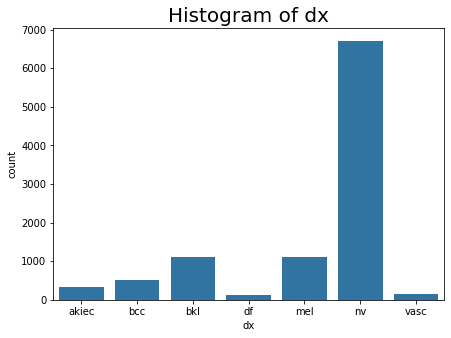

In [3]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='dx',data=df, color=colors[0])
plt.title('Histogram of dx', fontdict={'size': 20})
plt.show()

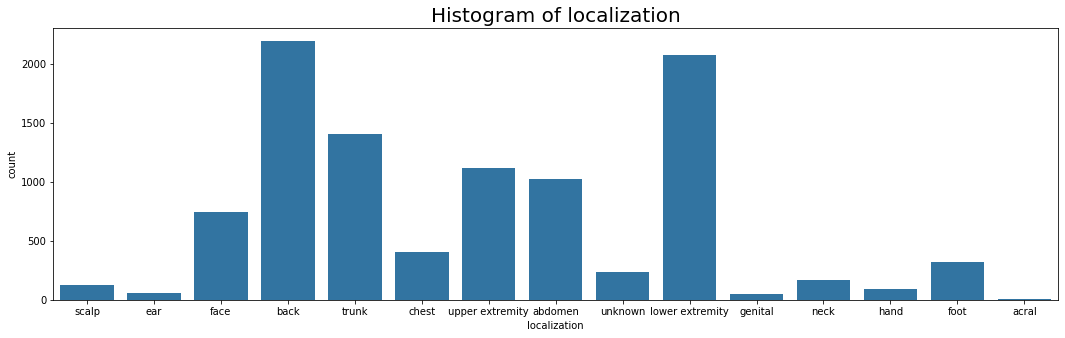

In [4]:
plt.figure(figsize=(18,5))
ax = sns.countplot(x='localization',data=df, color=colors[0])
plt.title('Histogram of localization', fontdict={'size': 20})
plt.show()

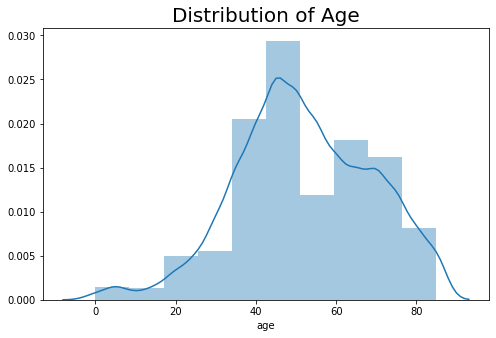

In [5]:
plt.figure(figsize=(8,5))
ax = sns.distplot(df['age'].dropna().values, 
                  bins=10, 
                  color=colors[0])
plt.title('Distribution of Age', fontdict={'size': 20})
plt.xlabel('age')
plt.show()

### Check the data quality

In [6]:
assert np.all(df.groupby('lesion_id')['sex'].nunique().values <= 1)
assert np.all(df.groupby('lesion_id')['age'].nunique().values <= 1)
assert np.all(0 <= df['age'].dropna().values)

# Missing values
df.isnull().sum().to_frame().transpose()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,target
0,0,0,0,0,57,0,0,0,0


### Check the image quality

In [7]:
import cv2

def resolution_detect(path):
    img = cv2.imread(path)
    img = np.array(img / 255, np.float32)
    resolution = cv2.Laplacian(img, cv2.CV_32F).std()
    
    return resolution

df['resolution'] = df['path'].apply(resolution_detect)
df['resolution'].describe().to_frame().transpose()

,count,mean,std,min,25%,50%,75%,max
resolution,10015.0,0.0378,0.014919,0.01291,0.029156,0.033275,0.043311,0.251459


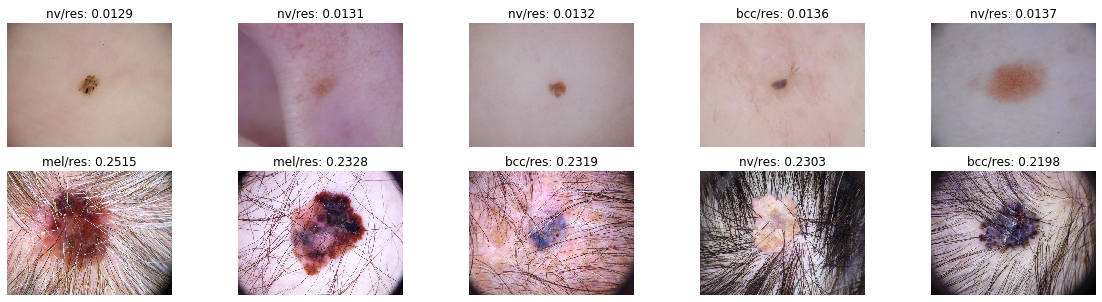

In [8]:
sorted_df = df.sort_values('resolution')

n_samples = 5
fig, ax = plt.subplots(2, n_samples, figsize = (4*n_samples, 5))
for i in range(n_samples):
    idx = i
    cls, res = sorted_df['dx'].iloc[idx], sorted_df['resolution'].iloc[idx]
    img = cv2.imread(sorted_df['path'].iloc[idx])
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    ax[0][i].imshow(img)
    ax[0][i].set_title(f'{cls}/res: {res:.4f}')
    ax[0][i].axis('off')
    
    idx = -i-1
    cls, res = sorted_df['dx'].iloc[idx], sorted_df['resolution'].iloc[idx]
    img = cv2.imread(sorted_df['path'].iloc[idx])
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    ax[1][i].imshow(img)
    ax[1][i].set_title(f'{cls}/res: {res:.4f}')
    ax[1][i].axis('off')

### Visualize different classes

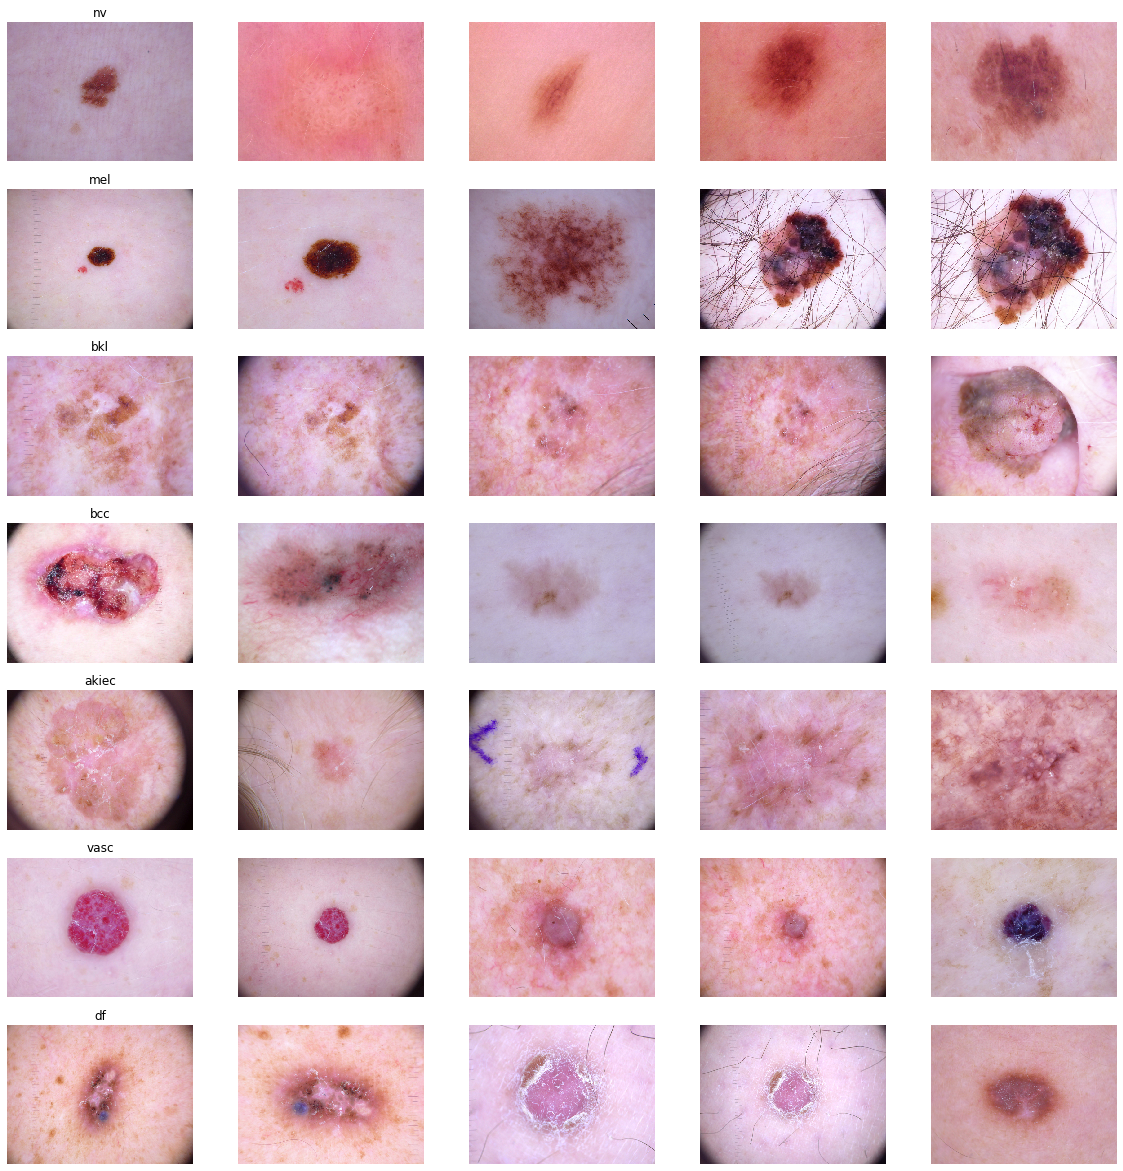

In [9]:
classes = df['dx'].value_counts()


fig, ax = plt.subplots(len(classes), n_samples, figsize = (4*n_samples, 21))
for i in range(len(classes)):
    cls, sub_df = classes.index[i], df.loc[df['dx']==classes.index[i]]
    ax[i][0].set_title(cls)
    for j in range(n_samples):
        img = cv2.imread(sub_df['path'].iloc[j])
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        ax[i][j].imshow(img)
        ax[i][j].axis('off')